# Packages

In [1]:
%pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client google-generativeai pandas seaborn

# Import All Necessary Libraries

In [1]:
from google.oauth2 import service_account
import google.generativeai as genai
import json
import pandas as pd
import seaborn as sns

c:\Users\zzehr\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set the Credentials

In [2]:
credentials = service_account.Credentials.from_service_account_file("ft_key.json")

genai.configure(credentials=credentials)

# Load Dataset

In [3]:
with open("dataset.json", "r", encoding="utf-8") as file:
    dataset = json.load(file)
    print(len(dataset))

529


# Select an Available Model & Name 

In [6]:
model_name = "bbs-fine-tune"

base_model = [
    m
    for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods
][0]

# Delete the Previous Version of Model (IF NECESSARY)

In [5]:
genai.delete_tuned_model(f"tunedModels/{model_name}")

# Fine Tuning of Model

Batch size arttıkça train hızlanır, ancak ram kullanımı da artacağından düzgün karar verilmelidir.

In [7]:
fine_tune = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=dataset,
    id=model_name,
    epoch_count=5,
    batch_size=4,
    learning_rate=0.001,
)

# Display Results & Plots

   step   mean_loss  epoch                     compute_time
0     1   71.521180      0 2024-09-13 12:27:34.528152+00:00
1     2   67.493350      0 2024-09-13 12:27:35.385162+00:00
2     3  109.944756      0 2024-09-13 12:27:36.125988+00:00
3     4   82.644820      0 2024-09-13 12:27:37.050391+00:00
4     5   47.889755      0 2024-09-13 12:27:37.797324+00:00


<Axes: xlabel='epoch', ylabel='mean_loss'>

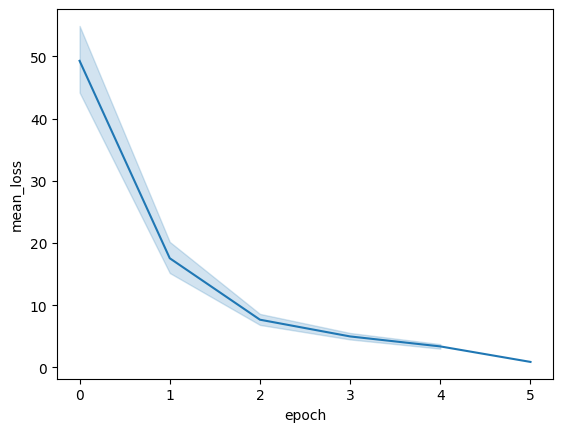

In [8]:
fine_tune_results = fine_tune.result(timeout=10800)

snapshots = pd.DataFrame(fine_tune_results.tuning_task.snapshots)

print(snapshots.head())

sns.lineplot(data=snapshots, x="epoch", y="mean_loss")

# Gather the Fine-Tuned Model

In [10]:
len(dataset)

215

In [10]:
model = genai.GenerativeModel(f"tunedModels/{model_name}")

# Evaluation and Testing of Model

In [30]:
from google.generativeai.types import HarmCategory, HarmBlockThreshold

result = model.generate_content("Arızalı sokak lambaları için nereye başvurabilirim?",
                                safety_settings={
                                    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
                                })
if result.parts:
    print(result.candidates[0])
else:
    print("No valid parts in the response.")
    for candidate in result.candidates:
        print(f"Candidate: {candidate}")
        print(f"Safety Ratings: {candidate.safety_ratings}")

index: 0
content {
  parts {
    text: "Arızalı sokak lambaları için belediyenizin ilgili birimine başvurarak durumu bildirebilirsiniz. Genellikle, bu tür şikayetler için 153 numaralı telefon hattı kullanılır."
  }
  role: "model"
}
finish_reason: STOP
safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

